# Neuron split

## Introduction
Most of the deep learning neural nets used nowadays are of a fixed size - the number of neurons and layers doesn't change throughout training, only the model weights change.

In this notebook I'd like to explore splitting a single neuron into 2 new ones, at the end of every epoch (the number 2 was arbitrarily selected, as well as splitting at end of epoch). The split is done randomly in such a way that the 2 new neurons are different from one another (essential for the gradient descent), but while keeping the output - or the next layers activations - identical to what they were before the split.

In this way we are expanding the network without changing it in the immediate moment after the split. But of course the hope is that the pslit will ultimately change the NN's capabilities/potential after additional training.

Below I experiment with a 3 layer dense fully connected NN - the simplest way to try out this idea. The neurons to be split will always be in the hidden layer, since the input and output have fixed sizes defined by the dataset and the number of classes.

## Mathematical proof
In the following proof I show that when splitting a neuron - or an activation $A^{[i]}$ - we can use 4 positive random variables $\alpha,\beta,\gamma,\delta$, under some constraints, and the network after the split will have the same output as before.

What actually is split are the weights and biases before and after this activation (the activation or neuron only exists temporarily as the intermediate values of the input data running through the NN).

Consider a 3 layer dense network. 
1. Input layer: $X=A^{[0]}∈R^{N\times C}$
1. Hidden layer $A^{[1]}∈R^{N\times H}$
1. Output layer $Y=A^{[2]}∈R^{N\times M}$

Our variables: 
* $N$ = number of samples (batch size)
* $C$ = number of input channels
* $H$ = hidden layer size
* $M$ = output size (number of classes for our 3 layer network)

Which means the network weights are:
* $W^{[1]}∈R^{C\times H}$, $b^{[1]}∈R^{H}$
* $W^{[2]}∈R^{H\times M}$, $b^{[2]}∈R^{M}$

No activations for now. If we make an analogy to the brain, the synapses are the weights $W^{[i]}$, and the Neurons are the activations $A^{[i]}$.

The goal is to randomly split a neuron in $A^{[1]}$ without changing the next activation $A^{[2]}$. 
In other words we go from $A^{[1]}∈R^{N\times H}$ ⇒ $A^{[1]}∈R^{N\times (H+1)}$ while $A^{[2]}$ doesn't change (the indices 1 and 2 can be generalized to i and i+1, but lets keep it simple).

Start with the mathematical definition of a standard dense fully connected layer with no activation (yet):

$\\a_{nm}^{[2]} = 
\sum_{h=1}^H a_{nh}^{[1]} w_{hm}^{[2]} +b_{m}^{[2]}= 
\sum_{h=1}^H ( \sum_{c=1}^C x_{nc} w_{ch}^{[1]}+b_{h}^{[1]})w_{hm}^{[2]}+b_{m}^{[2]}$

For simplicity, replace what is inside the sum as $F_h$:

$\\a_{nm}^{[2]} = F_h(1)+...+F_h(i)+...+F_h(H)+b_{m}^{[2]}$

Same as above, but we split the $i_{th}$ neuron into $k,j$:

$\\a_{nm}^{[2] split} = F_h(1)+...+F_h(j)+F_h(k)+...+F_h(H)+b_{m}^{[2]}$

We want the output ($A^{[2]}$) to stay constant after split:

$\\a_{nm}^{[2]}=a_{nm}^{[2] split}⟺F_h(i)=F_h(j)+F_h(k)⇒$

$\sum_{c=1}^C (x_{nc}w_{ci}^{[1]}+b_{i}^{[1]})w_{im}^{[2]}=
\sum_{c=1}^C (x_{nc} w_{cj}^{[1]} +b_{j}^{[1]})w_{jm}^{[2]}+\sum_{c=1}^C (x_{nc} w_{ck}^{[1]} +b_{k}^{[1]})w_{km}^{[2]}
$
$\\\sum_{c=1}^C x_{nc}w_{ci}^{[1]}w_{im}^{[2]}+b_{i}^{[1]}w_{im}^{[2]}=
\sum_{c=1}^C x_{nc}(w_{cj}^{[1]}w_{jm}^{[2]}+w_{ck}^{[1]}w_{km}^{[2]})+ b_{j}^{[1]}w_{jm}^{[2]}+b_{k}^{[1]}w_{km}^{[2]}
$

Above is true when (but not only when. Since $X$ varies, this is the only way forward):

1. $w_{ci}^{[1]}w_{im}^{[2]}=w_{cj}^{[1]}w_{jm}^{[2]}+w_{ck}^{[1]}w_{km}^{[2]}$ 
1. $b_{i}^{[1]}w_{im}^{[2]}=b_{j}^{[1]}w_{jm}^{[2]}+b_{k}^{[1]}w_{km}^{[2]}$

If we choose 4 random variables 𝛼,𝛽,𝛾,𝛿:
* $w_{cj}^{[1]}=\alpha w_{ci}^{[1]}$, $b_{j}^{[1]}=\alpha b_{i}^{[1]}$
* $w_{ck}^{[1]}=\beta  w_{ci}^{[1]}$, $b_{k}^{[1]}=\beta  b_{i}^{[1]}$
* $w_{jm}^{[2]}=\gamma w_{im}^{[2]}$
* $w_{km}^{[2]}=\delta w_{im}^{[2]}$

And if we plug in the above:
* Into (1): $1=\alpha\gamma+\beta\delta$
* Into (2): $1=\alpha\gamma+\beta\delta$

So if we normalize the random variables: $\alpha,\beta,\gamma,\delta\text{  /=} \sqrt{\alpha\gamma+\beta\delta}$, then the above will always be true.

Above was done with linear activation (no ReLU). It can be shown that when 𝛼,𝛾,𝛽,𝛿 are all positive, when adding ReLU everything still holds. Not necessarily true for other activation functions. Below we select them with $U[0.5,1]$, followed by normalization.

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# torch
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

## Data Load
Lets use the Fahsion MNist dataset, which can be loaded with PyTorch

In [4]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data', 
                                download=True, train=True)
testset = torchvision.datasets.FashionMNIST('./data', 
                                download=True, train=False)

# class names
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## Flattening and normalizing
trainset.data = trainset.data.reshape((len(trainset), -1)).type(dtype)/255-.5
testset.data = testset.data.reshape((len(testset), -1)).type(dtype)/255*.5

n_val = 10000
idxs = np.random.permutation(len(trainset))

val_idxs = idxs[:n_val]
train_idxs = idxs[n_val:]

x_val = trainset.data[val_idxs]
x_train = trainset.data[train_idxs]
y_val = trainset.targets[val_idxs]
y_train = trainset.targets[train_idxs]
x_test = testset.data
y_test = testset.targets

print('x, y train:',  tuple(x_train.shape), tuple(y_train.shape))
print('x, y val  :',  tuple(x_val.shape), tuple(y_val.shape))
print('x, y test :',  tuple(x_test.shape), tuple(y_test.shape))

x, y train: (50000, 784) (50000,)
x, y val  : (10000, 784) (10000,)
x, y test : (10000, 784) (10000,)


## Model class
Here I define the model class. 

The main thing to note here is the `split_neuron()` function at the end of the cell, which will randomly split a neuron.

In [5]:
class model:
    def __init__(self, sizes):
        
        ## Hyperparams
        self.initial_sizes = sizes
        self.layers = {}
        self.structure = []
        self.output = None
        self.loss = nn.CrossEntropyLoss()
        self.learning_rate = 1e-3
        
        ## Initialize layer weights
        for i in range(1, len(sizes)):
            m, n = sizes[i-1:i+1]
            w = torch.randn(m, n, device=device, dtype=dtype, requires_grad=True)    
            b = torch.zeros(n,    device=device, dtype=dtype, requires_grad=True)
            torch.nn.init.xavier_uniform_(w)
            self.layers[f'w{i}'] = w
            self.layers[f'b{i}'] = b
            self.structure.append(f'{i}')
        
        ## Track last layer, so won't be changed 
        ## (# classes is constant)
        self.L_out = f'{i}' 
        
    def forward(self, x, y, return_preds=False):
        A_prev = x
        for lyr in self.structure:
            Z = A_prev.mm(self.layers[f'w{lyr}'])+self.layers[f'b{lyr}']
            if lyr!=self.L_out:
                A_prev = Z.clamp(min=0)
            else:
                A_prev = Z
        
        if return_preds:
            return Z.detach().numpy().argmax(axis=1)
            self.output = None # Make sure grads won't be used here, could be test set.
            
        self.output = self.loss(A_prev, y) # pytorch cross entropy includes softmax.
        batch_loss = self.output.item()
        batch_acc = sum(A_prev.argmax(axis=1)==y).item()/len(y)
        return batch_loss, batch_acc
    
    def backward(self, ):
        assert self.output is not None, "Run forward before backward"
        self.output.backward()# grad of loss wrt all Tensors with requires_grad=True.
        with torch.no_grad(): # autograd doesn't need to track this
            for lyr in self.structure:
                self.layers[f'w{lyr}'] -= self.learning_rate * self.layers[f'w{lyr}'].grad
                self.layers[f'b{lyr}'] -= self.learning_rate * self.layers[f'b{lyr}'].grad 
                self.layers[f'w{lyr}'].grad.zero_()
                self.layers[f'b{lyr}'].grad.zero_()
                
    def get_sizes(self):
        return [tuple(self.layers[f'w{lyr}'].shape) 
                for lyr in self.structure]
    
    def total_params(self):
        return sum([self.layers[f'w{lyr}'].numel()+
                    self.layers[f'b{lyr}'].numel() 
                    for lyr in self.structure])
    
    def eval_lyr_neurons(self, x, y, layer_id):
        Neurons = len(self.layers[f'b{layer_id}'])
        losses = []
        
        with torch.no_grad():
            for n in range(Neurons):
                A_prev = x
                for lyr in self.structure:
                    Z = A_prev.mm(self.layers[f'w{lyr}'])+self.layers[f'b{lyr}']
                    if lyr!=self.L_out:
                        A_prev = Z.clamp(min=0)
                    else:
                        A_prev = Z

                    ## Zero out selected layer
                    if lyr==layer_id:
                        A_prev[:,n]=0
                        A_prev = A_prev*Neurons/(Neurons-1) # Normalizing as in dropout.

                losses.append(self.loss(A_prev, y).item())
        return losses
    
    def fire_rates(self, x, y, layer_id):
        with torch.no_grad():
            A_prev = x
            for lyr in self.structure:
                Z = A_prev.mm(self.layers[f'w{lyr}'])+self.layers[f'b{lyr}']
                if lyr!=self.L_out:
                    A_prev = Z.clamp(min=0)
                else:
                    A_prev = Z
                    
                if lyr==layer_id:
                    return ((A_prev>0).type(dtype).sum(axis=0)/A_prev.shape[0]).detach().numpy()
        
    def split_neuron(self, prev_layer_id, neuron_id):
        '''
        After normalization, expecting a*c+b*d==1 
        so that neuron split will not change output (at first).
        '''
        f = np.random.rand(4)/2+.5 # Uniform[0.5, 1). There are other ways.
        norm = (f[0]*f[2]+f[1]*f[3])**.5
        f/=norm
        a,b,c,d = f
        
        w1 = self.layers[f'w{prev_layer_id}'].detach().numpy()
        b1 = self.layers[f'b{prev_layer_id}'].detach().numpy()
        next_layer_id = self.structure[self.structure.index(prev_layer_id)+1]
        w2 = self.layers[f'w{next_layer_id}'].detach().numpy()
        
        ## Split for w1 (D_in, H)
        w1_to_split = w1[:,neuron_id, np.newaxis] # (D_in, 1)
        w1_rest = np.delete(w1, neuron_id, axis=1) # (D_in, H-1)
        w1_split1 = w1_to_split*a # (D_in, 1)
        w1_split2 = w1_to_split*b # (D_in, 1)
        w1_new = np.concatenate((w1_split1, w1_split2, w1_rest, ), axis=1) # (D_in, H+1)
        
        ## Split for b1 (H,)
        b1_to_split = b1[neuron_id, np.newaxis] # (1,)
        b1_rest = np.delete(b1, neuron_id) # (H-1,)
        b1_split1 = b1_to_split*a # (1,)
        b1_split2 = b1_to_split*b # (1,)
        b1_new = np.concatenate((b1_split1, b1_split2, b1_rest, ),) # (H+1,)
        
        ## Split for w2 (H, D_out)
        w2_to_split = w2[np.newaxis, neuron_id,:] # (1, D_out)
        w2_rest = np.delete(w2, neuron_id, axis=0) # (H-1, D_out)
        w2_split1 = w2_to_split*c # (1, D_out)
        w2_split2 = w2_to_split*d # (1, D_out)
        w2_new = np.concatenate((w2_split1, w2_split2, w2_rest), axis=0)

        ## Updating the weights
        self.layers[f'w{prev_layer_id}'] = torch.tensor(w1_new, device=device, dtype=dtype, requires_grad=True)
        self.layers[f'b{prev_layer_id}'] = torch.tensor(b1_new, device=device, dtype=dtype, requires_grad=True)
        self.layers[f'w{next_layer_id}'] = torch.tensor(w2_new, device=device, dtype=dtype, requires_grad=True)
        

## Load model
Initalizing the 3 layer dense NN.

In [13]:
D_in = x_train.shape[-1] # =784 (flattened image)
H = 10 # Hidden layer
D_out = len(classes) # =10

sizes = [D_in, H, D_out]
mymodel = model(sizes)
(mymodel.initial_sizes, mymodel.L_out, 
 mymodel.structure, mymodel.total_params())

([784, 10, 10], '2', ['1', '2'], 7960)

## Train loop
The neuron split below happens at the end of every epoch. 

We'll split a neuron in the hidden layer. But which neuron to split? 

Here we randomly select one, and further down I'll look at more interesting methods of choosing the neuron.

In [14]:
batch_size = 32 # arbitrarily chosen
batches = len(x_train)//batch_size # =468 if bs=128
epochs=20

data=[]
for epoch in range(epochs):
    
    idxs = np.random.permutation(len(x_train))
    for batch in range(batches):
        
        x_batch = x_train[idxs[batch_size*batch:batch_size*(batch+1)]]
        y_batch = y_train[idxs[batch_size*batch:batch_size*(batch+1)]]
        
        train_loss, train_acc = mymodel.forward(x_batch, y_batch)
        mymodel.backward()
        
    ## split
    split_layer_id = '1' # hidden layer is 1
    split_index = np.random.randint(mymodel.layers[f'b{split_layer_id}'].shape[0])
    mymodel.split_neuron(split_layer_id, split_index)
    
    ## Epoch end - Evaluation
    test_loss, test_acc = mymodel.forward(x_test, y_test)
    
    ## print progress
    print(f'E {epoch}', 
          f'Hidden size={mymodel.get_sizes()[0][1]}:', #=hidden layer size
          f'[loss {test_loss:.4} (train={train_loss:.4})]', 
          f'[acc {100*test_acc:.4}% (train={100*train_acc:.4}%)]', 
         )
    
    data.append((epoch, train_loss, train_acc, test_loss, test_acc))

cols = ['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc']   
lossdf = pd.DataFrame(data, columns=cols)

E 0 Hidden size=11: [loss 2.029 (train=1.744)] [acc 32.93% (train=31.25%)]
E 1 Hidden size=12: [loss 1.862 (train=1.122)] [acc 35.69% (train=75.0%)]
E 2 Hidden size=13: [loss 1.783 (train=1.041)] [acc 33.63% (train=59.38%)]
E 3 Hidden size=14: [loss 1.697 (train=1.091)] [acc 40.34% (train=65.62%)]
E 4 Hidden size=15: [loss 1.624 (train=0.7797)] [acc 45.85% (train=78.12%)]
E 5 Hidden size=16: [loss 1.564 (train=0.5728)] [acc 48.23% (train=84.38%)]
E 6 Hidden size=17: [loss 1.519 (train=0.5971)] [acc 49.63% (train=78.12%)]
E 7 Hidden size=18: [loss 1.483 (train=1.074)] [acc 50.82% (train=62.5%)]
E 8 Hidden size=19: [loss 1.458 (train=0.5413)] [acc 52.77% (train=84.38%)]
E 9 Hidden size=20: [loss 1.435 (train=0.5961)] [acc 54.71% (train=78.12%)]
E 10 Hidden size=21: [loss 1.417 (train=0.6882)] [acc 56.14% (train=78.12%)]
E 11 Hidden size=22: [loss 1.398 (train=0.7663)] [acc 56.39% (train=75.0%)]
E 12 Hidden size=23: [loss 1.382 (train=0.5877)] [acc 57.38% (train=78.12%)]
E 13 Hidden size=

## Plot lossdf

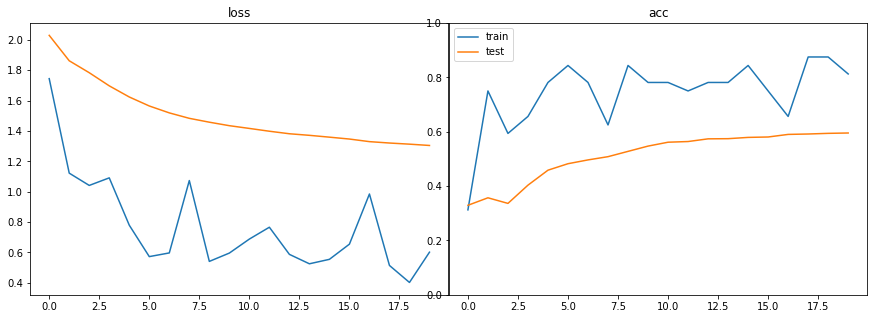

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', sharex=True)
fig.subplots_adjust(hspace = .3, wspace=.001)

for colname, ax in zip(['test_loss', 'test_acc'], axs.ravel()):
    
    test_data = lossdf[colname]
    train_data = lossdf[colname.replace('test', 'train')]
    
    ax.plot(train_data, label='train')
    ax.plot(test_data, label='test')
    
    name = colname.split('_')[1]
    ax.set_title(name)
    if name=='acc':
        ax.set_ylim([0,1])
plt.legend()
plt.show()

## Evaluation

True (Prediction)


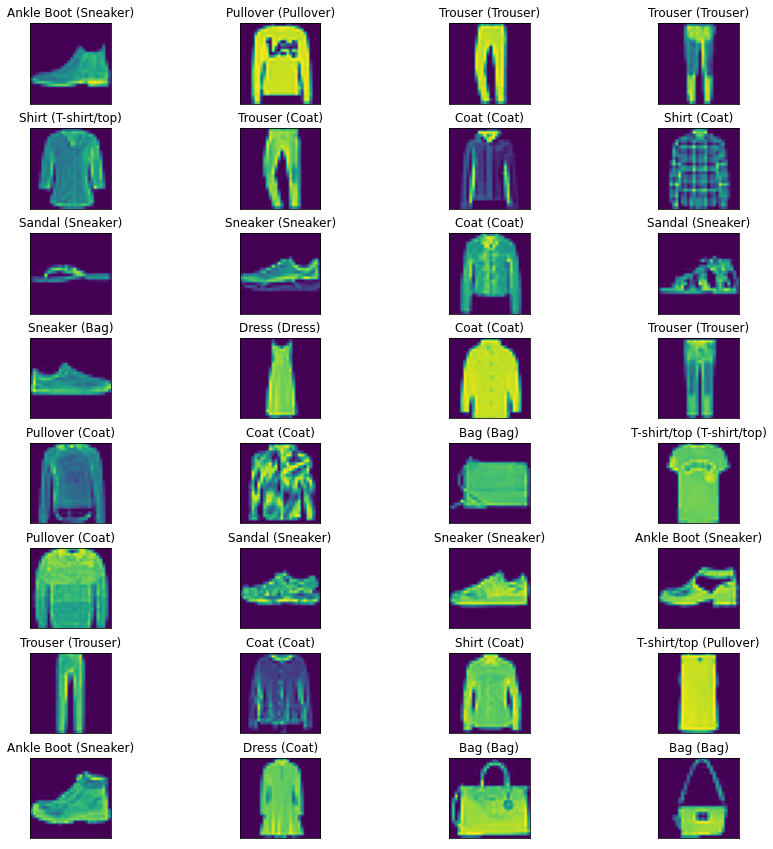

In [17]:
preds = mymodel.forward(x_test, y_test, return_preds=True)

fig, axs = plt.subplots(8,4, figsize=(15, 15), facecolor='w', sharex=True)
fig.subplots_adjust(hspace = .3, wspace=.001)
print('True (Prediction)')

for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_test.numpy()[i].reshape((28, 28)))
    ax.set_title(classes[y_test[i]]+f' ({classes[preds[i]]})')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## Which neuron to split?
Below we experiment with different methods to choose which neuron to split, including the no split scenario.

### Experiments
* **No split**: This is the experiment's control. Here the hidden layer size is intialized as the max size which the others will reach. So model starts large as opposed to the rest where starts small and expands with splits.
* **Random split**: A random index in the H dimension is selected to split.
* **Split with max loss check**: Using the validation data, the activations in the hidden layer are iterated over and zeroed one at a time - while checking how thiss affects the overall loss. Basically how is the loss affected if I remove a neuron (similar concept to dropout). So we split the neuron that when removed, validation loss is maximized.
* **Split with min loss check**: Same as above but minimum.
* **Split with loss check probs**: Similar to `Split with max loss check`, but with softmax stochastic selection. Skipping this option for now.
* **Split with max fire rate**: Fire rate is how often an neuron (after ReLU) has a non-zero value. Here we select the neuron with the maximal firing rate for the validation dataset.
* **Split with min fire rate**: Same as previous but minimum.
* **Split with .5 fire rate**: The neuron with a fire rate closest to 0.5 is split.

I ran each experiment 10 times, to see repeatability.

I must add that many of the hyperparamaters were arbitrarily sleected based on what usually works fairly well. Accuracy and loss can be improved with HP tuning, but the main idea of this experiment was to simply compare the no-split regular method with the other splitting options.

In [14]:
output_dir = './experiments/'
assert os.path.exists(output_dir), 'check output_dir exists'

experiments = ['no_split', 'rand_split', 
               'max_loss_split', 'min_loss_split', 
               'max_fr', 'min_fr', 'half_fr',]

history = {}
cols = ['epoch', 
        'train_loss', 'train_acc', 
        'test_loss', 'test_acc', 
        'tot_params', 'hidden_size']

## Training hyperparams
batch_size = 32
batches = len(x_train)//batch_size # =468 if bs=128
split_epochs = 50 # number of epochs where the model splits
still_epochs = 50 # number of epochs with no splitting, after split_epochs done.
split_layer_id = '1' # hidden layer

## Model initialization
H_init = 10
D_in = trainset.data.shape[-1] # =784
D_out = len(classes) # =10

## multiple runs for each experiment
runs=10

for run in range(runs):
    
    print('Run', run)

    for experiment in experiments:

        print(f'Running experiment:', experiment)

        # Hidden layer
        if experiment=='no_split':
            H = H_init+split_epochs
        else:
            H = H_init

        ## Init 3 layer model
        sizes = [D_in, H, D_out]
        mymodel = model(sizes)

        data=[]
        for epoch in range(split_epochs+still_epochs):

            idxs = np.random.permutation(len(x_train))
            for batch in range(batches):

                x_batch = x_train[idxs[batch_size*batch:batch_size*(batch+1)]]
                y_batch = y_train[idxs[batch_size*batch:batch_size*(batch+1)]]

                train_loss, train_acc = mymodel.forward(x_batch, y_batch)
                mymodel.backward()

            ## Split (or not) at epoch end
            if experiment=='no_split' or epoch>=split_epochs:
                pass
            elif experiment=='rand_split':
                split_index = np.random.randint(mymodel.layers[f'b{split_layer_id}'].shape[0])
                mymodel.split_neuron(split_layer_id, split_index)
            elif experiment=='max_loss_split':
                split_index = np.argmax(mymodel.eval_lyr_neurons(x_val, y_val, split_layer_id))
                mymodel.split_neuron(split_layer_id, split_index)
            elif experiment=='min_loss_split':
                split_index = np.argmin(mymodel.eval_lyr_neurons(x_val, y_val, split_layer_id))
                mymodel.split_neuron(split_layer_id, split_index)
            elif 'max_loss_probs_split':
                losseval = mymodel.eval_lyr_neurons(x_val, y_val, split_layer_id)
                exp = np.exp([10*i for i in losseval])
                probs = exp/np.sum(exp)# sort of softmax
                split_index = np.random.choice(len(losseval), p=probs)
                mymodel.split_neuron(split_layer_id, split_index)
            elif experiment=='max_fr':
                fire_rates = mymodel.fire_rates(x_val, y_val, split_layer_id)
                split_index = np.argmax(fire_rates)
                mymodel.split_neuron(split_layer_id, split_index)
            elif experiment=='min_fr':
                fire_rates = mymodel.fire_rates(x_val, y_val, split_layer_id)
                split_index = np.argmin(fire_rates)
                mymodel.split_neuron(split_layer_id, split_index)
            elif experiment=='half_fr':
                fire_rates = mymodel.fire_rates(x_val, y_val, split_layer_id)
                split_index = np.argmin((.5-fire_rates)**2)
                mymodel.split_neuron(split_layer_id, split_index)

            ## Epoch end evaluation
            test_loss, test_acc = mymodel.forward(x_test, y_test)
            tot_params = mymodel.total_params()
            hidden_size = mymodel.get_sizes()[0][1]

            data.append((epoch, train_loss, train_acc, test_loss, test_acc, tot_params, hidden_size))
        
        ## End of experiment
        df = pd.DataFrame(data, columns=cols)
        df.to_csv(output_dir+f'run-{run}-e-{experiment}.csv', index=False)

Run 0
Running experiment: no_split
Running experiment: rand_split
Running experiment: max_loss_split
Running experiment: min_loss_split
Running experiment: max_fr
Running experiment: min_fr
Running experiment: half_fr
Run 1
Running experiment: no_split
Running experiment: rand_split
Running experiment: max_loss_split
Running experiment: min_loss_split
Running experiment: max_fr
Running experiment: min_fr
Running experiment: half_fr
Run 2
Running experiment: no_split
Running experiment: rand_split
Running experiment: max_loss_split
Running experiment: min_loss_split
Running experiment: max_fr
Running experiment: min_fr
Running experiment: half_fr
Run 3
Running experiment: no_split
Running experiment: rand_split
Running experiment: max_loss_split
Running experiment: min_loss_split
Running experiment: max_fr
Running experiment: min_fr
Running experiment: half_fr
Run 4
Running experiment: no_split
Running experiment: rand_split
Running experiment: max_loss_split
Running experiment: min_los

## Plotting
Can start from here

In [27]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

output_dir = './experiments/'
filenames = [output_dir+f for f in os.listdir(output_dir)]
runs = max([int(f.split('-')[1]) for f in filenames])
names = set([f.split('-')[-1][:-4] for f in filenames])
colors = ['blue', 'green', 'red', 'yellow', 'purple', 
          'orange', 'gray', 'black', 'magenta', 'pink', ]
color_dict = dict((n,c) for c,n in zip(colors, names))
len(filenames)

70

## Test loss

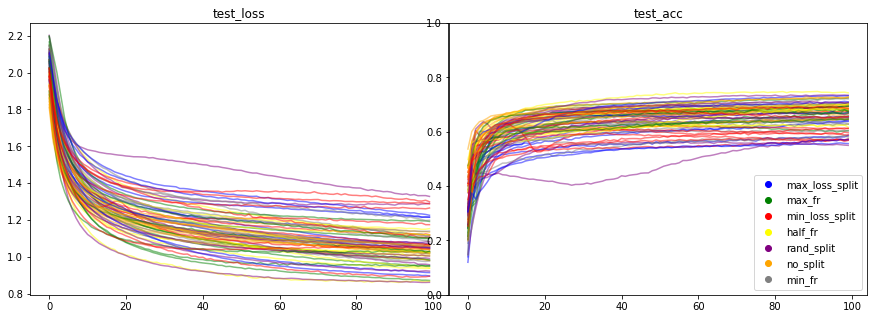

In [35]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', sharex=False)
fig.subplots_adjust(hspace = .3, wspace=.001)

for colname, ax in zip(['test_loss', 'test_acc'], axs.ravel()):
    for f in filenames:
        lossdf = pd.read_csv(f)
        name=f.split('-')[-1][:-4]
        data = lossdf[colname]
        ax.plot(data, label=name, color=color_dict[name], alpha=.5)
        ax.set_title(colname)
        if colname.endswith('acc'):
            ax.set_ylim([0,1])

## Fake lines for legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_dict.values()]
plt.legend(markers, color_dict.keys(), numpoints=1)
plt.show()

## Test loss - plotted separately
The graph above is too messy, lets plot the same but separately

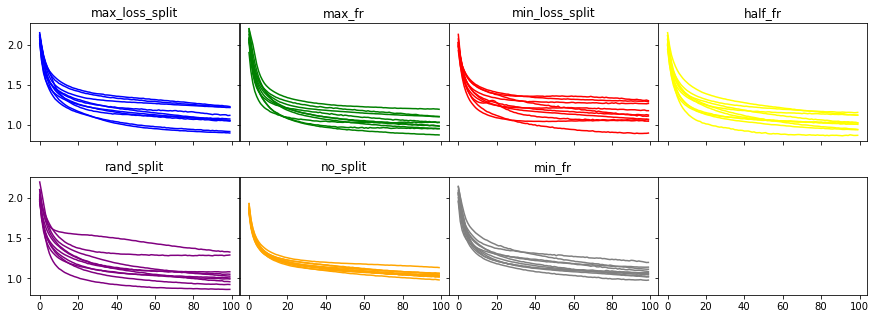

In [36]:
fig, axs = plt.subplots(2,4, figsize=(15, 5), facecolor='w', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .3, wspace=.001)

col='test_loss'
for name, ax in zip(names, axs.ravel()):
    for f in filenames:
        fname = f.split('-')[-1][:-4]
        if name!=fname:
            continue
        lossdf = pd.read_csv(f)
        
        data = lossdf[col]
        ax.plot(data, label=name, color=color_dict[name])
        ax.set_title(name)
        if col=='acc':
            ax.set_ylim([0,1])
            
plt.show()

## Train loss

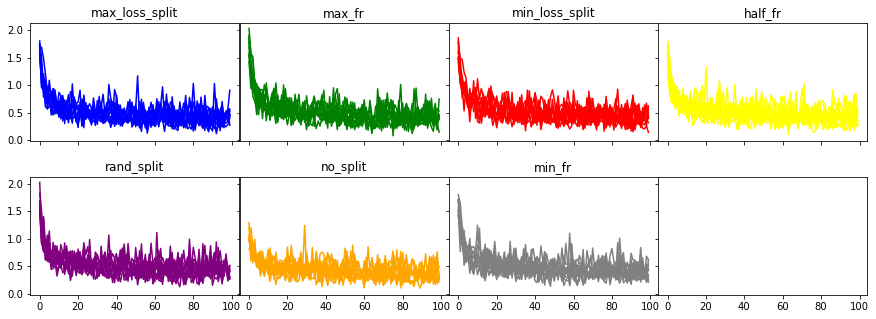

In [37]:
fig, axs = plt.subplots(2,4, figsize=(15, 5), facecolor='w', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .3, wspace=.001)

col='train_loss'
for name, ax in zip(names, axs.ravel()):
    for f in filenames:
        fname = f.split('-')[-1][:-4]
        if name!=fname:
            continue
        lossdf = pd.read_csv(f)
        
        data = lossdf[col]
        ax.plot(data, label=name, color=color_dict[name])
        ax.set_title(name)
        if col=='acc':
            ax.set_ylim([0,1])
            
plt.show()

## Test Accuracy

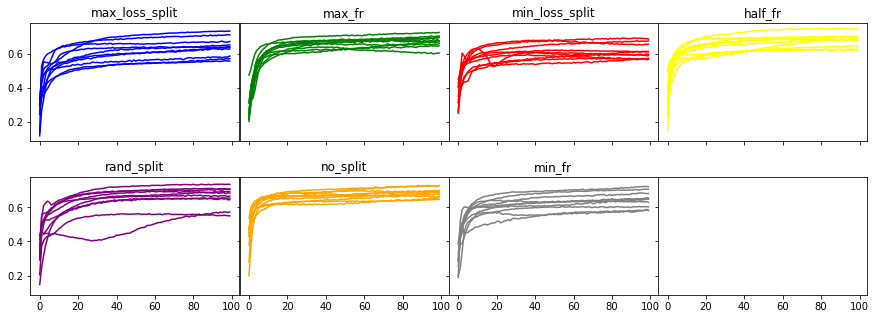

In [38]:
fig, axs = plt.subplots(2,4, figsize=(15, 5), facecolor='w', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .3, wspace=.001)

col='test_acc'
for name, ax in zip(names, axs.ravel()):
    for f in filenames:
        if name!=f.split('-')[-1][:-4]:
            continue
        lossdf = pd.read_csv(f)
        
        data = lossdf[col]
        ax.plot(data, label=name, color=color_dict[name])
        ax.set_title(name)
        if col=='val_acc':
            ax.set_ylim([0,1])
plt.show()

## Total params

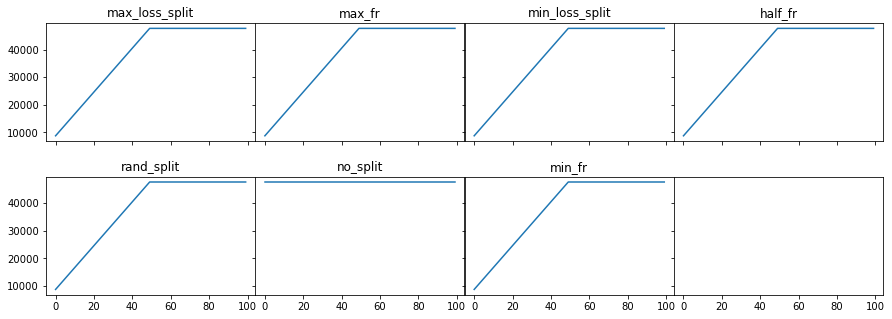

In [41]:
fig, axs = plt.subplots(2,4, figsize=(15, 5), facecolor='w', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .3, wspace=.001)

col='tot_params'
for name, ax in zip(names, axs.ravel()):
    f = f'./experiments/run-0-e-{name}.csv'
    lossdf = pd.read_csv(f)
    data = lossdf[col]
    ax.plot(data, label=name)
    ax.set_title(name)
plt.show()

## Test loss final value

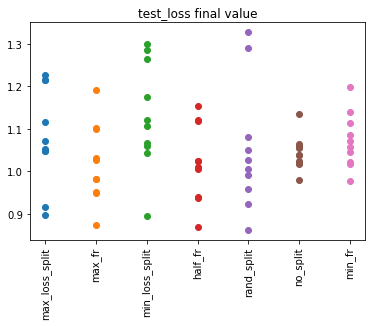

In [60]:
col='test_loss'
for i, name in enumerate(names):
    finals = []
    for f in filenames:
        fname = f.split('-')[-1][:-4]
        if name!=fname:
            continue
        lossdf = pd.read_csv(f)
        finals.append(lossdf[col].iloc[-1])
    plt.scatter(i*np.ones(len(finals)), finals)
plt.xticks(list(range(len(names))), labels=names, rotation=90)
plt.title(col+' final value')
plt.show()

## Test accuracy final value

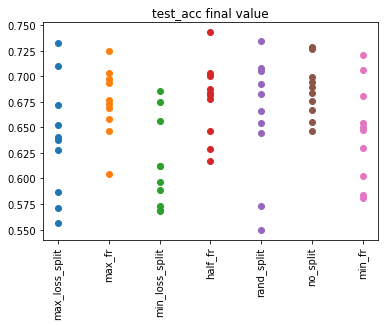

In [61]:
col='test_acc'
for i, name in enumerate(names):
    finals = []
    for f in filenames:
        fname = f.split('-')[-1][:-4]
        if name!=fname:
            continue
        lossdf = pd.read_csv(f)
        finals.append(lossdf[col].iloc[-1])
    plt.scatter(i*np.ones(len(finals)), finals)
plt.xticks(list(range(len(names))), labels=names, rotation=90)
plt.title(col+' final value')
plt.show()

## Summary
Surpisingly, the split runs were more variable than the stable one. 
It seems that the neuron splitting works best with half or max firing rate, but other oprions also have interesting results. The main problem with this type of network is that it intorduces more hyperparameters, but it might be useful in certain applications.
The main issue here seems to be when to split and which neuron to split. None of the methods seemed that great, so maybe these decisions need to be made by a separate NN.

### Notes
* dtype in torch very important for debugging - when using torch.float (=float32) the differences in output after Neuron splitting were noticeable, (1e-5 to 1e-7) but when doing the same split with torch.float64 the difference reduces to negligible (1e-16 to 1e-17). So its apparent that the output is same after split, when measured accurately enough. [dtypes in torch](https://pytorch.org/docs/stable/tensors.html)